# ADL-DL-PreHack-Pixies - TelcoPlan MLClassification SageMaker  


### About Notebook Instance 

The notebook instance is the research which customer data of a mobile telecommunication company. The goal is to develop ML model to predict rental plan for each customer will activate in a month. A rental plan will provide as a monthly subscription, and it contains free usage of quoata in terms of data, voice and text messages.


### Objective
The objective of this competition is to predict the rental plan each customer will use within the next month. There are 8 rental plans available in the market for all customers. These plans are numbered from PKG1 to PKG8.



## Pypi Package request and installation (fresh run)

In [ ]:
!pip install imblearn boto3 missingo 

In [16]:
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
import re
import boto3
from sklearn.preprocessing import StandardScaler
from imblearn.combine import SMOTETomek
import seaborn as sns
import missingno as msno

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score,confusion_matrix,accuracy_score




/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


## S3 data pump (not required in Google colabs backend)

In [ ]:

s3_bucket = 'pixies-datalake'

from sagemaker import get_execution_role
role = get_execution_role()

remote_file='adl-ai-summit-2021-prehackathon.zip'
dest_file='/home/ec2-user/SageMaker/output.zip'

s3=boto3.resource('s3')
s3.Bucket(s3_bucket).download_file(remote_file, dest_file)
print('file downloaded .: '+dest_file)



## Import csv dataset into IPYNB

In [7]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load



train_dataset_remote_filepath = 'https://raw.githubusercontent.com/RoshiniFernando/ADL-AI-Summit-2021-PreHackathon/master/Dataset/train_dataset.csv'
test_dataset_remote_filepath = 'https://raw.githubusercontent.com/RoshiniFernando/ADL-AI-Summit-2021-PreHackathon/master/Dataset/test_dataset.csv'
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [6]:
# regex creation for remove un-identified chars


regex = re.compile(r"\[|\]|<", re.IGNORECASE)

## Data Import

In [12]:
train_df = pd.read_csv(train_dataset_remote_filepath,index_col='primary_identifier')

train_df.head()

,device_type,device_category,gender,district_name,age_group,network_stay,average_monthly_bill_amount,dusage_sum,dusage_min,dusage_max,dusage_avg,dusage_days,dusage_stddev,vusage_onnet_sum,vusage_onnet_max,vusage_onnet_min,vusage_onnet_days,vusage_onnet_avg,vusage_onnet_stddev,vusage_offnet_sum,vusage_offnet_max,vusage_offnet_min,vusage_offnet_days,vusage_offnet_avg,vusage_offnet_stddev,number_of_fixed_bb_accounts,number_of_iptv_accounts,add_on_tot_rental,add_on_count,next_month_plan
primary_identifier,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
6875768,4G,Smartphone,MALE,Kegalle,40-50,219,761.62,6317.0,2.773958,622.685848,210.579939,30.0,197.116822,0.0,0.0,0.0,0.0,NaN,0.0,677.0,152.866667,0.0,27.0,25.099383,34.759221,0.0,1.0,NaN,NaN,PKG2
6406277,4G,Smartphone,MALE,Galle,40-50,36,2482.52,28365.0,3.079438,2569.429138,945.531235,30.0,573.299639,0.0,0.0,0.0,0.0,NaN,0.0,76.0,35.433333,0.0,15.0,5.071111,6.779644,0.0,0.0,600.0,2.0,PKG1
3563570,4G,Smartphone,MALE,Kandy,30-40,186,1565.55,18581.0,48.193713,2739.515326,619.378810,30.0,619.750500,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.000000,0.0,0.0,NaN,0.000000,0.0,0.0,0.0,1.0,PKG6
1853666,4G,Smartphone,FEMALE,Colombo,40-50,24,2397.49,91071.0,22.437842,7523.355693,3035.708609,30.0,2174.203127,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.000000,0.0,0.0,NaN,0.000000,0.0,0.0,1110.0,2.0,PKG4
2794331,4G,Smartphone,FEMALE,Kandy,50-60,37,2501.75,19736.0,53.302092,1239.220170,657.889802,30.0,329.152516,0.0,0.0,0.0,0.0,NaN,0.0,258.0,87.616667,0.0,23.0,11.256522,16.224071,0.0,1.0,1350.0,2.0,PKG4


# *Exploritary Data Analysis




Analyze the dataset with deep datascience understandings before training the MLModel. Under this section, we gothrough multiple piplines and stages on missing data, categorical data and numerical data.







### Analysis of `NaN`, Missing data on original dataset

Missing data is the probably one of the most common issues when working with real (non-synthesis) datasets. cata can be missing for multitude of reasons. 


In [14]:
train_df.info()
train_df.shape

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10500 entries, 6875768 to 3569439
Data columns (total 30 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   device_type                  10477 non-null  object 
 1   device_category              10470 non-null  object 
 2   gender                       10365 non-null  object 
 3   district_name                10500 non-null  object 
 4   age_group                    10365 non-null  object 
 5   network_stay                 10500 non-null  int64  
 6   average_monthly_bill_amount  10500 non-null  float64
 7   dusage_sum                   10500 non-null  float64
 8   dusage_min                   10500 non-null  float64
 9   dusage_max                   10500 non-null  float64
 10  dusage_avg                   9642 non-null   float64
 11  dusage_days                  10500 non-null  float64
 12  dusage_stddev                10500 non-null  float64
 13  vusage_o

(10500, 30)

In [15]:
train_df.isna().sum()

device_type                      23
device_category                  30
gender                          135
district_name                     0
age_group                       135
network_stay                      0
average_monthly_bill_amount       0
dusage_sum                        0
dusage_min                        0
dusage_max                        0
dusage_avg                      858
dusage_days                       0
dusage_stddev                     0
vusage_onnet_sum                  0
vusage_onnet_max                  0
vusage_onnet_min                  0
vusage_onnet_days                 0
vusage_onnet_avg               8672
vusage_onnet_stddev               0
vusage_offnet_sum                 0
vusage_offnet_max                 0
vusage_offnet_min                 0
vusage_offnet_days                0
vusage_offnet_avg              3313
vusage_offnet_stddev              0
number_of_fixed_bb_accounts       0
number_of_iptv_accounts           0
add_on_tot_rental           

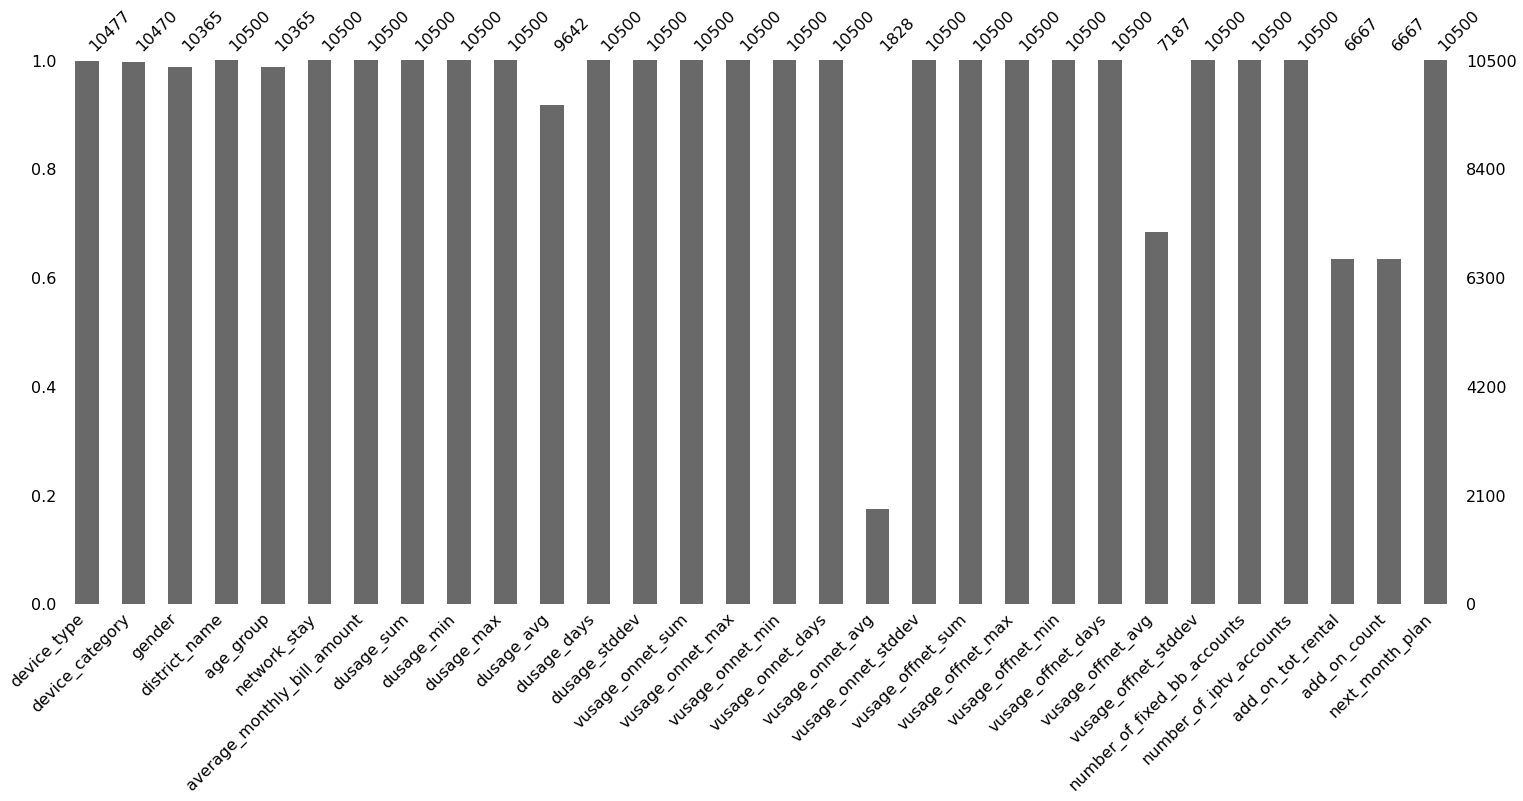

In [17]:
msno.bar(train_df)

 The view of `msno.bar` and `msno.matrix` shows missing values of entire dataset by columns. `vusage_onnet_avg` have the largest portion of missing values. Other data columns can be imputed by advanced data manipulators. So to improve the model creation we drop `vusage_onnet_avg`

## Imputing Null Values

In [18]:
cat_features=[i for i in train_df.columns if train_df.dtypes[i]=='object']
num_features=train_df.select_dtypes(include=np.number).columns.tolist()

In [19]:
# read and process data
class DataPrep():

  # read the data
  def read_data(self, path):
    data = pd.read_csv(path)
    return data

  # preprocessing
  # def preprocess_data(self, data):
    # categorical + numerical + timestamp columns

  def treat_null(self, data):
    global categorical, discrete, continous, cols
    categorical = []
    discrete = []
    continous = []
    for col in data.columns:
      if data[col].dtype == object:
        categorical.append(col)
      elif data[col].dtype in ['int16', 'int32', 'int64']:
        discrete.append(col)
      elif data[col].dtype in ['float16', 'float32', 'float64']:
        continous.append(col)

    cols = discrete + categorical + continous
    data = data[cols]

    # null values
    # data = preprocess_data(data)
    indices = []
    for col in cols:
      k = data.columns.get_loc(col)
      indices.append(k)

    for col in indices:
      if data.columns[col] in discrete:
        x = data.iloc[:, col].values
        x = x.reshape(-1,1)
        imputer = SimpleImputer(missing_values=np.nan, strategy='median')
        imputer = imputer.fit(x)
        x = imputer.transform(x)
        data.iloc[:, col] = x

      if data.columns[col] in continous:
        x = data.iloc[:, col].values
        x = x.reshape(-1,1)
        imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
        imputer = imputer.fit(x)
        x = imputer.transform(x)
        data.iloc[:, col] = x

      elif data.columns[col] in categorical:
        x = data.iloc[:, col].values
        x = x.reshape(-1,1)
        imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        imputer = imputer.fit(x)
        x = imputer.transform(x)
        data.iloc[:, col] = x     

    return data

  # outlier detection + treatment
  def outlier_correcter(self, data):
    # data = treat_null(data)
    for col in discrete + continous:
      data[col] = data[col].clip(lower=data[col].quantile(0.10), upper=data[col].quantile(0.90))
    return data

#   # feature generation
#   def generate_features(self, data):
#     data['both_loans'] = 0 #default to 0
#     data.loc[data['housing'] == 'yes', 'both_loans'] = 1
#     data.loc[data['loan'] == 'no', 'both_loans'] = 1 # change to 1 if one has both loans
#     data['total_contacts'] = data['campaign'] + data['previous']

    def squares(data, ls):
        m = data.shape[1]
        for l in ls:
            # data = data.assign(newcol=pd.Series(np.log(1.01+data[l])).values)
            data = data.assign(newcol=pd.Series(data[l]*data[l]).values)    
            data.columns.values[m] = l + '_sq'
            m += 1
        return data

    log_features = ['duration', 'cons.price.idx', 'emp.var.rate', 'cons.conf.idx', 'euribor3m']

    data = squares(data, log_features)

    return data

  # scaling numerical
  def scaler(self, data):
    # data = outlier_correcter(data)
    indices = []
    for col in discrete + continous:
      k = data.columns.get_loc(col)
      indices.append(k)

      for col in indices:
        x = data.iloc[:, col].values
        x = x.reshape(-1,1)
        imputer = StandardScaler()
        imputer = imputer.fit(x)
        x = imputer.transform(x)
        data.iloc[:, col] = x  

    return data

  # encoding categorical
  def encoder(self, data):
    # data = scaler(data)
    cols = categorical.copy()
    cols.remove('next_month_plan')
    data = pd.get_dummies(data, columns = cols)
    return data

  # class imbalance
  def over_sample(self, data):
    # data = scaler(data)
    subscribers = data[data.next_month_plan == 'yes']
    non_subscribers = data[data.y == 'no']

    subscribers_upsampled = resample(subscribers, replace=True, # sample with replacement
                        n_samples = len(non_subscribers), # match number in majority class
                        random_state = 42) # reproducible results

    data = pd.concat([subscribers_upsampled, non_subscribers])

In [20]:
# creating a object from predifined data preparation class
d = DataPrep()


# remove null values from dataset. by categorical and numerical basis
train_df = d.treat_null(train_df)

# remove extreme outliers data
train_df = d.outlier_correcter(train_df)


#train_df = d.generate_features(train_df)
train_df = d.scaler(train_df)


train_df = d.encoder(train_df)


train_df.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in train_df.columns.values]

In [21]:
train_df.next_month_plan.value_counts()

PKG1    3673
PKG3    1717
PKG5    1558
PKG2    1354
PKG6     740
PKG4     735
PKG7     364
PKG8     359
Name: next_month_plan, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


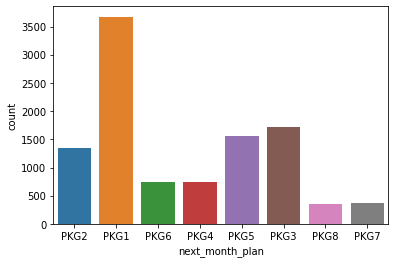

In [22]:
sns.countplot(train_df.next_month_plan)

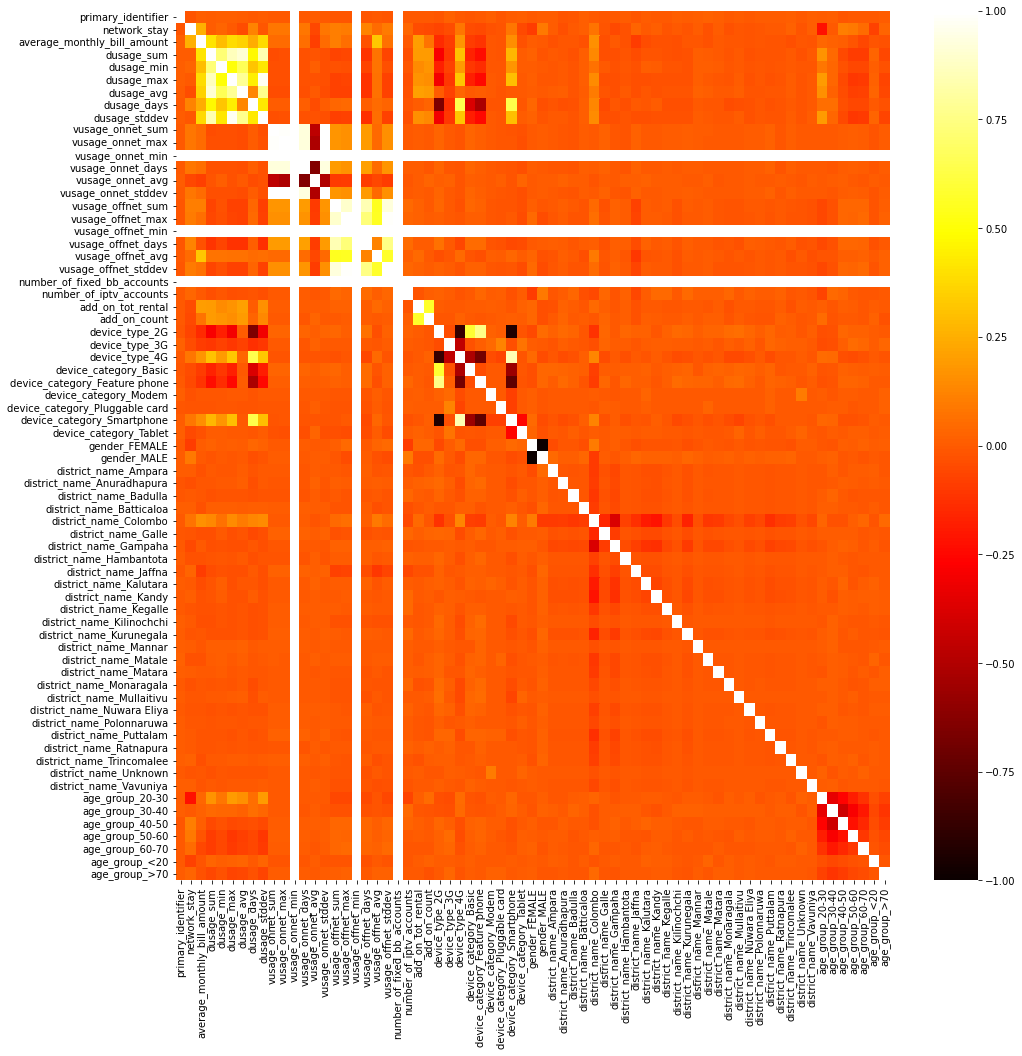

In [ ]:
plt.figure(figsize=(16,16))
sns.heatmap(train_df.corr(),cmap='hot')

In [23]:


features = ['primary_identifier', 'network_stay',
       'average_monthly_bill_amount', 'dusage_sum', 'dusage_min', 'dusage_max',
       'dusage_avg', 'dusage_days', 'dusage_stddev', 'vusage_onnet_sum',
       'vusage_onnet_max', 'vusage_onnet_days',
       'vusage_onnet_avg', 'vusage_onnet_stddev', 'vusage_offnet_sum',
       'vusage_offnet_max', 'vusage_offnet_min', 'vusage_offnet_days',
       'vusage_offnet_avg', 'vusage_offnet_stddev',
       'number_of_fixed_bb_accounts', 'number_of_iptv_accounts',
       'add_on_tot_rental', 'add_on_count', 'device_type_2G', 'device_type_3G',
       'device_type_4G', 'device_category_Basic',
       'device_category_Feature phone', 'device_category_Modem',
       'device_category_Pluggable card', 'device_category_Smartphone',
       'device_category_Tablet', 'gender_FEMALE', 'gender_MALE',
       'district_name_Ampara', 'district_name_Anuradhapura',
       'district_name_Badulla', 'district_name_Batticaloa',
       'district_name_Colombo', 'district_name_Galle', 'district_name_Gampaha',
       'district_name_Hambantota', 'district_name_Jaffna',
       'district_name_Kalutara', 'district_name_Kandy',
       'district_name_Kegalle', 'district_name_Kilinochchi',
       'district_name_Kurunegala', 'district_name_Mannar',
       'district_name_Matale', 'district_name_Matara',
       'district_name_Monaragala', 'district_name_Mullaitivu',
       'district_name_Nuwara Eliya', 'district_name_Polonnaruwa',
       'district_name_Puttalam', 'district_name_Ratnapura',
       'district_name_Trincomalee', 'district_name_Unknown',
       'district_name_Vavuniya', 'age_group_20-30', 'age_group_30-40',
       'age_group_40-50', 'age_group_50-60', 'age_group_60-70',
       'age_group__20', 'age_group_>70']





In [ ]:
x_train,x_valid,y_train,y_valid = train_test_split(train_df[features].values,train_df.next_month_plan.values,test_size=0.2,train_size=0.8)

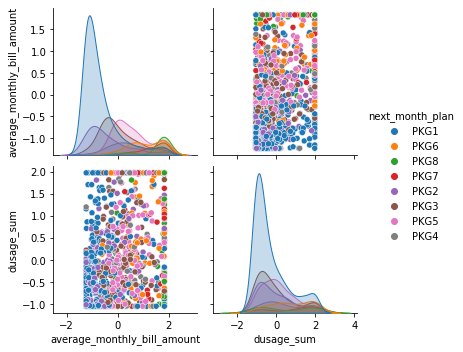

In [ ]:
sns.pairplot(data=train_df.sample(n=1000),hue='next_month_plan',vars=['average_monthly_bill_amount','dusage_sum'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


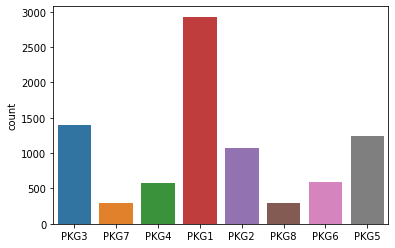

In [ ]:
sns.countplot(y_train)

In [ ]:
combine = SMOTETomek(random_state = 42)
X_train_resample, y_train_resample = combine.fit_resample(x_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


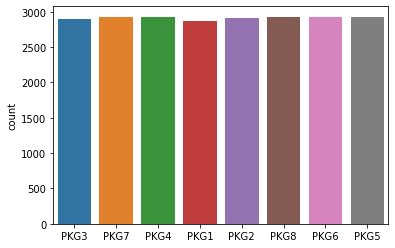

In [ ]:
sns.countplot(y_train_resample)

## Modeling

In [ ]:
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier


model = XGBClassifier(
 learning_rate =0.01,
 n_estimators=5000,
 max_depth=4,
 min_child_weight=6,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 reg_alpha=0.005,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)


In [ ]:
model.fit(X_train_resample,y_train_resample)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0,
              learning_rate=0.01, max_delta_step=0, max_depth=4,
              min_child_weight=6, missing=None, n_estimators=5000, n_jobs=1,
              nthread=4, objective='multi:softprob', random_state=0,
              reg_alpha=0.005, reg_lambda=1, scale_pos_weight=1, seed=27,
              silent=None, subsample=0.8, verbosity=1)

In [ ]:
preds = model.predict(x_valid)

Accuracy is:  0.5328571428571428


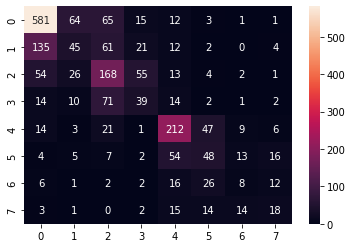

In [ ]:
ac = accuracy_score(y_valid,preds)
print('Accuracy is: ',ac)

cm = confusion_matrix(y_valid,preds)
sns.heatmap(cm,annot=True,fmt="d")


In [ ]:
f1_score(y_valid, preds, average='macro')


0.3843287402695139

Feature: 0, Score: 0.00840
Feature: 1, Score: 0.01240
Feature: 2, Score: 0.09809
Feature: 3, Score: 0.01553
Feature: 4, Score: 0.01700
Feature: 5, Score: 0.01421
Feature: 6, Score: 0.01724
Feature: 7, Score: 0.01205
Feature: 8, Score: 0.01547
Feature: 9, Score: 0.02248
Feature: 10, Score: 0.01648
Feature: 11, Score: 0.00000
Feature: 12, Score: 0.01971
Feature: 13, Score: 0.00815
Feature: 14, Score: 0.02978
Feature: 15, Score: 0.08590
Feature: 16, Score: 0.03094
Feature: 17, Score: 0.00000
Feature: 18, Score: 0.05313
Feature: 19, Score: 0.03155
Feature: 20, Score: 0.01398
Feature: 21, Score: 0.00000
Feature: 22, Score: 0.00660
Feature: 23, Score: 0.01254
Feature: 24, Score: 0.01902
Feature: 25, Score: 0.01797
Feature: 26, Score: 0.01082
Feature: 27, Score: 0.01026
Feature: 28, Score: 0.00605
Feature: 29, Score: 0.01476
Feature: 30, Score: 0.00000
Feature: 31, Score: 0.00000
Feature: 32, Score: 0.00932
Feature: 33, Score: 0.00445
Feature: 34, Score: 0.02195
Feature: 35, Score: 0.00000
Fe

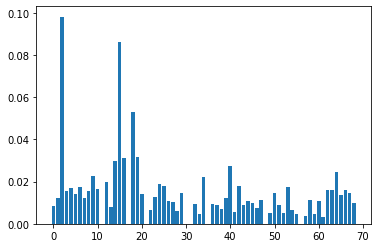

In [ ]:
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

# Submission


In [ ]:
test_df = pd.read_csv('/content/test_dataset.csv')

In [ ]:
test_df_p = test_df

In [ ]:
# read and process data
class DataPrep():

  # read the data
  def read_data(self, path):
    data = pd.read_csv(path)
    return data

  # preprocessing
  # def preprocess_data(self, data):
    # categorical + numerical + timestamp columns

  def treat_null(self, data):
    global categorical, discrete, continous, cols
    categorical = []
    discrete = []
    continous = []
    for col in data.columns:
      if data[col].dtype == object:
        categorical.append(col)
      elif data[col].dtype in ['int16', 'int32', 'int64']:
        discrete.append(col)
      elif data[col].dtype in ['float16', 'float32', 'float64']:
        continous.append(col)

    cols = discrete + categorical + continous
    data = data[cols]

    # null values
    # data = preprocess_data(data)
    indices = []
    for col in cols:
      k = data.columns.get_loc(col)
      indices.append(k)

    for col in indices:
      if data.columns[col] in discrete:
        x = data.iloc[:, col].values
        x = x.reshape(-1,1)
        imputer = SimpleImputer(missing_values=np.nan, strategy='median')
        imputer = imputer.fit(x)
        x = imputer.transform(x)
        data.iloc[:, col] = x

      if data.columns[col] in continous:
        x = data.iloc[:, col].values
        x = x.reshape(-1,1)
        imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
        imputer = imputer.fit(x)
        x = imputer.transform(x)
        data.iloc[:, col] = x

      elif data.columns[col] in categorical:
        x = data.iloc[:, col].values
        x = x.reshape(-1,1)
        imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        imputer = imputer.fit(x)
        x = imputer.transform(x)
        data.iloc[:, col] = x     

    return data

  # outlier detection + treatment
  def outlier_correcter(self, data):
    # data = treat_null(data)
    for col in discrete + continous:
      data[col] = data[col].clip(lower=data[col].quantile(0.10), upper=data[col].quantile(0.90))
    return data

#   # feature generation
#   def generate_features(self, data):
#     data['both_loans'] = 0 #default to 0
#     data.loc[data['housing'] == 'yes', 'both_loans'] = 1
#     data.loc[data['loan'] == 'no', 'both_loans'] = 1 # change to 1 if one has both loans
#     data['total_contacts'] = data['campaign'] + data['previous']

    def squares(data, ls):
        m = data.shape[1]
        for l in ls:
            # data = data.assign(newcol=pd.Series(np.log(1.01+data[l])).values)
            data = data.assign(newcol=pd.Series(data[l]*data[l]).values)    
            data.columns.values[m] = l + '_sq'
            m += 1
        return data

    log_features = ['duration', 'cons.price.idx', 'emp.var.rate', 'cons.conf.idx', 'euribor3m']

    data = squares(data, log_features)

    return data

  # scaling numerical
  def scaler(self, data):
    # data = outlier_correcter(data)
    indices = []
    for col in discrete + continous:
      k = data.columns.get_loc(col)
      indices.append(k)

      for col in indices:
        x = data.iloc[:, col].values
        x = x.reshape(-1,1)
        imputer = StandardScaler()
        imputer = imputer.fit(x)
        x = imputer.transform(x)
        data.iloc[:, col] = x  

    return data

  # encoding categorical
  def encoder(self, data):
    # data = scaler(data)
    cols = categorical.copy()
    ##cols.remove('primary_identifier')
    data = pd.get_dummies(data, columns = cols)
    return data

  # class imbalance
  def over_sample(self, data):
    # data = scaler(data)
    subscribers = data[data.next_month_plan == 'yes']
    non_subscribers = data[data.y == 'no']

    subscribers_upsampled = resample(subscribers, replace=True, # sample with replacement
                        n_samples = len(non_subscribers), # match number in majority class
                        random_state = 42) # reproducible results

    data = pd.concat([subscribers_upsampled, non_subscribers])

In [ ]:
ds = DataPrep()


test_df = ds.read_data('/content/test_dataset.csv')


test_df = ds.treat_null(test_df)



test_df = ds.outlier_correcter(test_df)




test_df = ds.scaler(test_df)


test_df = ds.encoder(test_df)


test_df.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in test_df.columns.values]


In [ ]:
preds = model.predict(test_df[features].values)

In [ ]:
preds


array(['PKG2', 'PKG2', 'PKG3', ..., 'PKG4', 'PKG7', 'PKG3'], dtype=object)

In [ ]:
output = pd.DataFrame({'primary_identifier': test_df_p.primary_identifier,
                       'next_month_plan': preds})

In [ ]:
output.next_month_plan.replace("PKG1",1,inplace=True)
output.next_month_plan.replace("PKG2",2,inplace=True)
output.next_month_plan.replace("PKG3",3,inplace=True)
output.next_month_plan.replace("PKG4",4,inplace=True)
output.next_month_plan.replace("PKG5",5,inplace=True)
output.next_month_plan.replace("PKG6",6,inplace=True)
output.next_month_plan.replace("PKG7",7,inplace=True)
output.next_month_plan.replace("PKG8",8,inplace=True)

In [ ]:
output.to_csv('adl-dl-pixies-007.csv', index=False)